**Scripts de dados para aprofundamento do POP - PMUS** (Aplicação na cidade de Niterói - RJ)


A proposta desse Colab é subsdiar o POP do PMUS com possíveis ferramentas de código aberto que possam contribuir na criação de um diagnóstico mais completo através do uso de novas ferramentas tecnologicas.  

In [ ]:
#Instalação das bibliotecas utilizadas

!pip install geobr --quiet # https://pypi.org/project/geobr/
!pip install osmnx --quiet
!pip install geobr --quiet
!pip install contextily --quiet
!pip install basedosdados --quiet
!pip install tobler --quiet
!pip install tobler.util --quiet
!pip install osmnx --quiet
!pip install h3 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.11.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.9.3 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
basedosdados 1.6.11 requires shapely<2.0.0,>=1.6.0, but you have shapely 2.0.5 which is incompatible.
geobr 0.2.1 requires shapely<2.0.0,>=1.7.0, but you have shapely 2.0.5 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.11.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompat

####**INTRODUÇÃO**

In [ ]:
#Armazenando informações da cidade de estudo em variáveis
#Niterói
#330330

cidade = input("Digite o nome da cidade: ")
codigo_municipio = float(input("Digite o código da cidade: "))

Digite o nome da cidade: Niterói
Digite o código da cidade: 330330


####**DIAGNÓSTICO**

#####***Análise do contexto atual da cidade***

Mapa de localização da cidade no contexto regional

In [ ]:
import folium
import geobr
from geobr import read_municipality

# Carregar os dados geoespaciais de todos os municípios do estado do Rio de Janeiro
rj_municipios = read_municipality(code_muni="RJ", year=2020)

# Separar Niterói dos outros municípios
niteroi = rj_municipios[rj_municipios['name_muni'] == cidade]
outros_municipios = rj_municipios[rj_municipios['name_muni'] != cidade]

# Coordenadas centrais de Niterói para centralizar o mapa
latitude = -22.885897
longitude = -43.115299

# Centralizar em Niterói
map_rj = folium.Map(location=[latitude, longitude], zoom_start=10)

# Adiciona os limites dos outros municípios com linhas finas
folium.GeoJson(outros_municipios, style_function=lambda x: {'color': 'gray', 'weight': 1}, name='Outros Municípios').add_to(map_rj)

# Adiciona os limites de Niterói com uma linha mais espessa e preenchida de preto
folium.GeoJson(niteroi, style_function=lambda x: {'color': 'black', 'weight': 3, 'fillColor': 'black', 'fillOpacity': 0.5}, name='Niterói').add_to(map_rj)

# Adiciona um marcador com o nome de Niterói
folium.Marker(
    [latitude, longitude],
    popup='Niterói',
    icon=folium.Icon(color='black')
).add_to(map_rj)

# Adiciona uma legenda personalizada
legend_html = '''
     <div style="
     position: fixed;
     bottom: 50px; left: 50px; width: 150px; height: 90px;
     background-color: white;
     border:2px solid grey;
     z-index:9999;
     font-size:14px;
     ">
     &nbsp; <b>Legenda</b> <br>
     &nbsp; <i style="color:black;">&#9679;</i>&nbsp; Niterói <br>
     &nbsp; <i style="color:gray;">&#9679;</i>&nbsp; Outros Municípios<br>
     </div>
     '''

map_rj.get_root().html.add_child(folium.Element(legend_html))

# Adiciona a camada de controle
folium.LayerControl().add_to(map_rj)

# Imprime o mapa criado
map_rj

In [ ]:
ibge_id = geobr.lookup_muni(
    cidade
).code_muni.squeeze()

cidade_analise = (
    geobr
    .read_municipality(ibge_id)
    .to_crs(31983)
)

**Utilização da biblioteca H3 para estudos de acessibilidade**

A biblioteca H3 é uma biblioteca de indexação geoespacial desenvolvida pela Uber. Ela permite dividir a superfície da Terra em uma grade de hexágonos de diferentes resoluções. Cada hexágono é identificado por um índice único, facilitando a análise espacial e a visualização de dados geográficos. H3 é amplamente usada para tarefas como análise de acessibilidade, visualização de densidade populacional e otimização de rotas. [Bibioteca H3](https://www.uber.com/en-BR/blog/h3/)

In [ ]:
import geopandas as gpd
import h3
import shapely
from tobler.util import h3fy
import geobr


# Carregar os dados geoespaciais de todos os municípios do estado do Rio de Janeiro
municipios = geobr.read_municipality(code_muni='RJ', year=2020)
cidade_estudo = municipios[municipios['name_muni'] == cidade]

# Obter os limites do município de Niterói
limites_cidade = cidade_estudo.geometry.values[0]

# Criar um GeoDataFrame a partir do objeto limites_niteroi e definir a CRS
limites_cidade_gdf = gpd.GeoDataFrame(geometry=[limites_cidade], crs='EPSG:4326')

# Obtenção dos dados dos hexágonos que interseccionam a área de análise
# Usando resolução 9 como exemplo, ajuste conforme necessário
resolucao = 9
hex_df = h3fy(limites_cidade_gdf, resolucao)

# Verificar as colunas do DataFrame retornado por h3fy
print(hex_df.columns)

# Ajustar a extração dos hex IDs com base nas colunas disponíveis
if 'h3_index' in hex_df.columns:
    hex_ids = hex_df['h3_index'].tolist()
else:
    hex_ids = hex_df.index.tolist()

# Criação de lista para armazenar polígonos
lista_poligonos = [shapely.Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in hex_ids]

# Criar um GeoDataFrame contendo a geometria e o id de cada hexágono
malha_hexagonal = gpd.GeoDataFrame({"geometry": lista_poligonos, "hex_id": hex_ids}, crs="EPSG:4326")

# Mostrar geometrias na tela
#malha_hexagonal.plot()

Index(['geometry'], dtype='object')


#####**Estudo de acessibilidade**

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
#CARREGANDO DADOS DE SAÚDE E EDUCAÇÃO PARA ESTUDOS DE ACESSIBILIDADE


#Obtenção da base de escolas do brasil
escolas_br = geobr.read_schools()
#Filtragem pelas escolas de Niterói
escolas_niteroi = escolas_br[escolas_br['name_muni'] == cidade]
#conversão do sistema de projeção
escolas_niteroi_proj = escolas_niteroi.to_crs('EPSG:31983')



#Obtenção da base de saúde no brasil
saude_br = geobr.read_health_facilities()
#Filtragem pelas escolas de Niterói
saude_niteroi = saude_br[saude_br['code_muni'] == 330330]
#conversão do sistema de projeção
saude_niteroi_proj = saude_niteroi.to_crs('EPSG:31983')

In [ ]:
import plotly.express as px

#verificação das intersecções entre hexágonos e escolas
malha_com_escolas = malha_hexagonal.sjoin(escolas_niteroi, how='left')

#agregação dos resultados da intersecção
malha_com_escolas = malha_com_escolas.dissolve(by='hex_id', aggfunc={'name_school':'count'})

#criação de uma nova coluna para a quantidade de escolas
malha_com_escolas['quantidade_escolas'] = malha_com_escolas['name_school']

#execute comando scatter_mapbox
fig = px.choropleth_mapbox(
    malha_com_escolas,
    geojson=malha_com_escolas.geometry,
    locations=malha_com_escolas.index,
    color='quantidade_escolas',
    mapbox_style="open-street-map",
    zoom=12,
    center = {"lat": -22.885897, "lon": -43.115299},
    opacity = 0.5
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:2195: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4674




Em estudos de acessibilidade, grafos são usados para modelar e analisar a conectividade e a facilidade de movimentação dentro de um espaço geográfico.

*   Vértices (nós): Representam locais de interesse, como escolas, hospitais, ou cruzamentos de ruas.
*   Arestas (ligações): Representam as rotas ou caminhos entre esses locais.

Usando grafos, é possível avaliar quão acessíveis são os serviços e infraestruturas dentro de uma área, identificando caminhos mais curtos, áreas de difícil acesso e otimização de rotas.

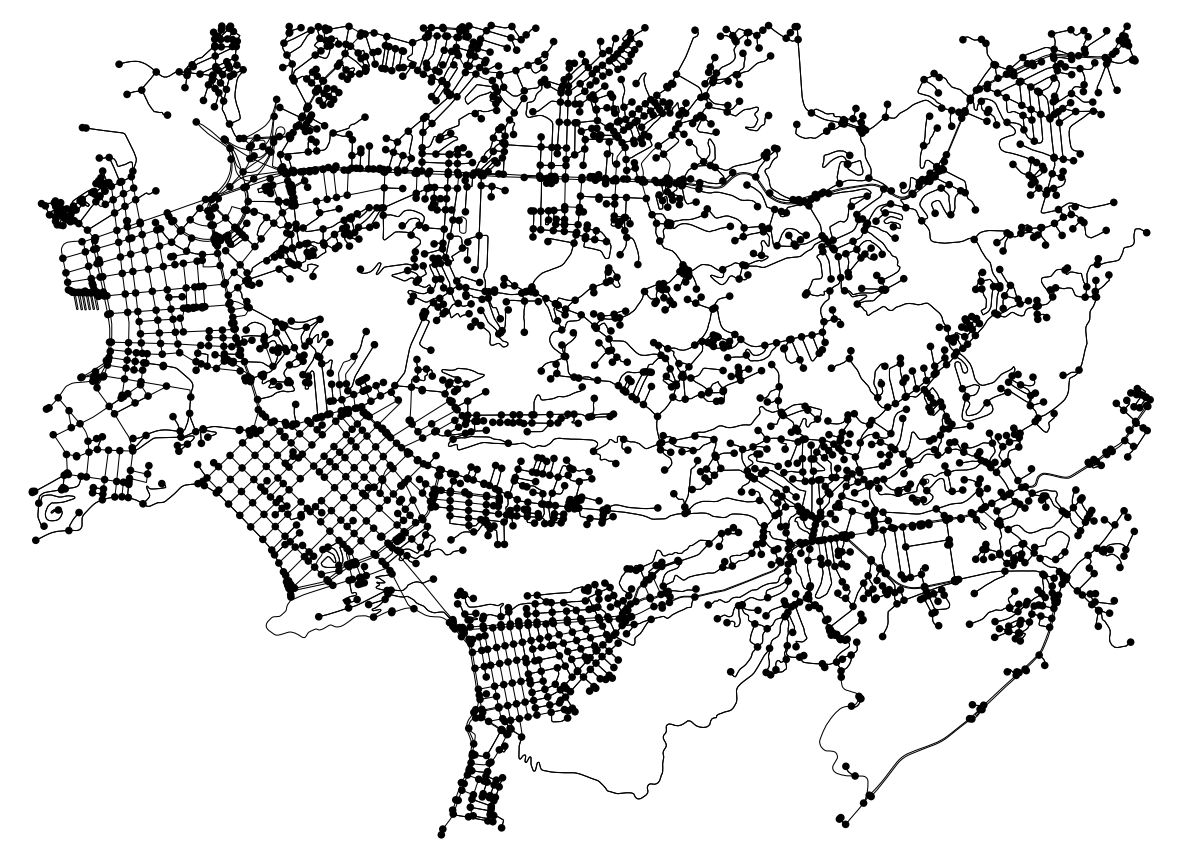

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [ ]:
#definição das coordenadas da área de análise
import osmnx
norte = -22.8700
sul = -22.9300
leste = -43.0400
oeste = -43.1300

vertices = [ [oeste, norte], [leste, norte], [leste, sul], [oeste, sul] ]

#importação de grafo contendo apenas as vias utilizáveis por carros
grafo_niteroi = osmnx.graph_from_bbox(bbox=[norte,sul,leste,oeste], network_type='drive')

#desenho do grafo na tela
osmnx.plot.plot_graph(grafo_niteroi, figsize=[15,15], bgcolor = 'white', node_size = 30, node_color = 'black', edge_color = 'black', edge_linewidth=0.75)

In [ ]:
!pip install pandana --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pandana as pdna
import osmnx as ox

# Obter os nós e arestas do grafo
nodes, edges = ox.graph_to_gdfs(grafo_niteroi, nodes=True, edges=True)

# Criar um índice único para cada nó
node_map = pd.Series(index=nodes.index, data=np.arange(len(nodes)))
nodes['node_id'] = nodes.index.map(node_map)
edges['from_node'] = edges.apply(lambda row: node_map[ox.distance.nearest_nodes(grafo_niteroi, row.geometry.centroid.x, row.geometry.centroid.y)], axis=1)
edges['to_node'] = edges.apply(lambda row: node_map[ox.distance.nearest_nodes(grafo_niteroi, row.geometry.centroid.x, row.geometry.centroid.y)], axis=1)

# Criar a rede Pandana
def create_pandana_network(edges):
    x = np.concatenate([edges['geometry'].apply(lambda g: g.coords[0][0]).values, edges['geometry'].apply(lambda g: g.coords[-1][0]).values])
    y = np.concatenate([edges['geometry'].apply(lambda g: g.coords[0][1]).values, edges['geometry'].apply(lambda g: g.coords[-1][1]).values])
    lengths = edges['length'].values
    from_node = np.concatenate([edges['from_node'].values, edges['to_node'].values])
    to_node = np.concatenate([edges['to_node'].values, edges['from_node'].values])

    # Crie a rede Pandana
    net = pdna.Network(x, y, lengths, from_node, to_node)
    return net

# Criar a rede Pandana
net = create_pandana_network(edges)

ValueError: All arrays must be of the same length

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx
import pandana as pdna


# Carregar o grafo da cidade
grafo_niteroi = osmnx.graph_from_bbox(north=norte, south=sul, east=leste, west=oeste, network_type='drive')

# Função para calcular a distância entre dois pontos no grafo
def calcular_distancia(ponto_a, ponto_b):
    if ponto_a != ponto_b:
        menor_caminho = osmnx.routing.shortest_path(grafo_niteroi, ponto_a, ponto_b)
        if menor_caminho:
            route_gdf = osmnx.routing.route_to_gdf(grafo_niteroi, menor_caminho, weight='length')
            return route_gdf['length'].sum()
    return np.inf

# Adicionar coordenadas dos centros dos hexágonos ao DataFrame
malha_com_escolas['latitude'] = malha_com_escolas['geometry'].centroid.y
malha_com_escolas['longitude'] = malha_com_escolas['geometry'].centroid.x

# Criar uma matriz para armazenar distâncias
n_hex = len(malha_com_escolas)
dist_matrix = np.zeros((n_hex, n_hex))

# Preencher a matriz de distâncias
for i in range(n_hex):
    lat_a, lon_a = malha_com_escolas.iloc[i][['latitude', 'longitude']]
    ponto_a = osmnx.distance.nearest_nodes(grafo_niteroi, lon_a, lat_a)

    for j in range(n_hex):
        if i != j:
            lat_b, lon_b = malha_com_escolas.iloc[j][['latitude', 'longitude']]
            ponto_b = osmnx.distance.nearest_nodes(grafo_niteroi, lon_b, lat_b)
            dist_matrix[i, j] = calcular_distancia(ponto_a, ponto_b)

# Calcular as distâncias ponderadas
dist_escolas = np.zeros(n_hex)
quantidade_escolas = malha_com_escolas['quantidade_escolas'].values

for i in range(n_hex):
    dist_escolas[i] = np.sum(dist_matrix[i] * quantidade_escolas) / np.sum(quantidade_escolas)

# Adicionar a coluna ao DataFrame
malha_com_escolas['dist_escolas'] = dist_escolas


<ipython-input-74-2b13341eb136>:9: FutureWarning:

The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123

<ipython-input-74-2b13341eb136>:21: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


<ipython-input-74-2b13341eb136>:22: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import pandana
import osmnx

# Carregar o grafo da cidade
nodes, edges = osmnx.graph_to_gdfs(grafo_niteroi, nodes=True, edges=True)

# Resetar o índice para garantir que os índices sejam contínuos e extrair dados necessários
nodes = nodes.reset_index()
edges = edges.reset_index()

# Verificar se os dados estão corretos
print(nodes.head())
print(edges.head())

# Certifique-se de que as colunas usadas para criar a rede sejam do tipo correto
# Convertendo para arrays NumPy
nodes_x = nodes['x'].to_numpy()
nodes_y = nodes['y'].to_numpy()
edges_source = edges['source'].to_numpy()
edges_target = edges['target'].to_numpy()
edges_length = edges['length'].to_numpy()

# Criar a rede de transporte com Pandana
network = pandana.Network(
    nodes_x,        # Coordenadas x dos nós
    nodes_y,        # Coordenadas y dos nós
    edges_source,   # Nós de origem
    edges_target,   # Nós de destino
    edges_length    # Comprimentos das arestas
)

# Passo 2: Calcular Distâncias entre Hexágonos e Escolas
def calcular_distancia_escuela_hexagono(hex_centro, escolas):
    lat_hex, lon_hex = hex_centro
    distancias = []
    for _, escola in escolas.iterrows():
        lat_esc, lon_esc = escola.geometry.centroid.y, escola.geometry.centroid.x
        try:
            distancia = network.shortest_path((lon_hex, lat_hex), (lon_esc, lat_esc), weight='length')
            distancias.append(distancia)
        except Exception as e:
            print(f"Erro ao calcular a distância: {e}")
    return np.mean(distancias) if distancias else np.nan

# Criar uma coluna para armazenar a distância média das escolas
malha_com_escolas['distancia_media'] = malha_com_escolas.apply(
    lambda row: calcular_distancia_escuela_hexagono(
        (row.geometry.centroid.y, row.geometry.centroid.x),
        escolas_niteroi_proj
    ),
    axis=1
)

# Mostrar o resultado
print(malha_com_escolas[['hex_id', 'quantidade_escolas', 'distancia_media']])

       osmid          y          x  ref            highway  street_count  \
0  162943115 -22.875479 -43.110345  322  motorway_junction             3   
1  162961670 -22.879380 -43.110807  NaN                NaN             3   
2  162961673 -22.878431 -43.110570  NaN                NaN             3   
3  162962888 -22.879238 -43.110981  NaN                NaN             3   
4  162964746 -22.878155 -43.109335  NaN                NaN             3   

                      geometry  
0  POINT (-43.11035 -22.87548)  
1  POINT (-43.11081 -22.87938)  
2  POINT (-43.11057 -22.87843)  
3  POINT (-43.11098 -22.87924)  
4  POINT (-43.10934 -22.87815)  
           u           v  key                             osmid  oneway lanes  \
0  162943115  2624854016    0            [1134257866, 16135719]    True     1   
1  162943115  1830310769    0                          16137613    True     3   
2  162961670  8250215732    0                         784357985    True     4   
3  162961673   163039

KeyError: 'source'

In [ ]:
#laço de repetição medindo a distância entre todos os pares de hexágonos
cont = 0

for index, item in malha_com_escolas.iterrows():
  latitudeA = item['geometry'].centroid.y
  longitudeA = item['geometry'].centroid.x
  ponto_a = osmnx.distance.nearest_nodes(grafo_niteroi, longitudeA, latitudeA)
  dist_escolas, cont_escolas = 0,0

  for indexB, itemB in malha_com_escolas.iterrows():
    if index != indexB and itemB['quantidade_escolas'] > 0:
      latitudeB = itemB['geometry'].centroid.y
      longitudeB = itemB['geometry'].centroid.x
      ponto_b = osmnx.distance.nearest_nodes(grafo_niteroi, longitudeB, latitudeB)

      # Check if points are different before calculating path
      if ponto_a != ponto_b:
        menor_caminho = osmnx.routing.shortest_path(grafo_niteroi, ponto_a, ponto_b)
        if menor_caminho:
          route_gdf = osmnx.routing.route_to_gdf(grafo_niteroi, menor_caminho, weight='length')
          distancia = route_gdf['length'].sum()
          dist_escolas += distancia * itemB['quantidade_escolas'] # Moved inside the if menor_caminho block

    elif index == indexB:
      cont_escolas += item['quantidade_escolas']

  malha_com_escolas.at[index, 'dist_escolas'] = dist_escolas / cont_escolas if cont_escolas > 0 else 0

AttributeError: 'GeoDataFrame' object has no attribute 'intertuples'

In [ ]:
malha_com_escolas['dist_escolas'].min()

0.0

In [ ]:
malha_com_escolas.head()

,geometry,name_school,quantidade_escolas,dist_escolas
hex_id,,,,
89a8a069493ffff,"POLYGON ((-43.08962 -22.87342, -43.08856 -22.8...",0,0,0.0
89a8a069497ffff,"POLYGON ((-43.09266 -22.87180, -43.09159 -22.8...",0,0,0.0
89a8a06949bffff,"POLYGON ((-43.08651 -22.87194, -43.08545 -22.8...",0,0,0.0
89a8a0694d3ffff,"POLYGON ((-43.08037 -22.87208, -43.07931 -22.8...",0,0,0.0
89a8a06b003ffff,"POLYGON ((-43.10857 -22.89470, -43.10751 -22.8...",0,0,0.0


In [ ]:
#execute comando scatter_mapbox
fig = px.choropleth_mapbox(
    malha_com_escolas,
    geojson=malha_com_escolas.geometry,
    locations=malha_com_escolas.index,
    color='dist_escolas',
    mapbox_style="open-street-map",
    zoom=12,
    center = {"lat": -22.885897, "lon": -43.115299},
    opacity = 0.5
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

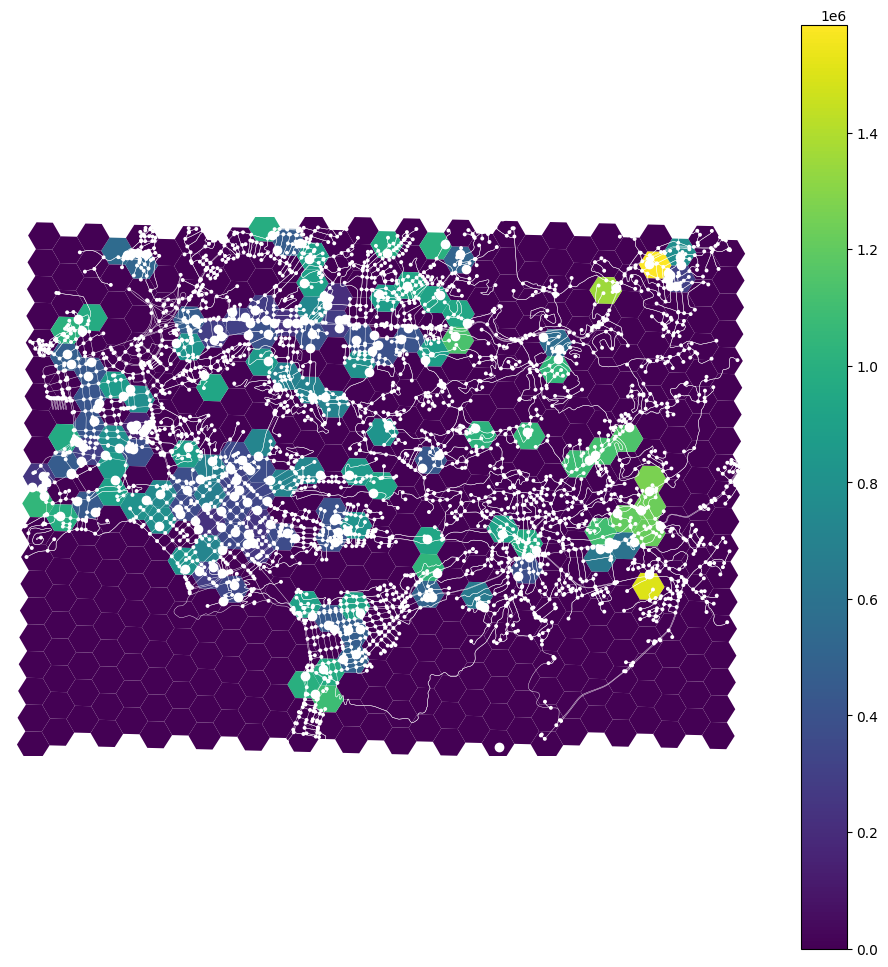

(-22.93, -22.87)

In [ ]:
#importa biblioteca de gráficos e mapas
import matplotlib.pyplot as plt

#definie configurações gerais
fig, ax = plt.subplots(figsize=[12,12])

#adiciona camadas do mapa
malha_com_escolas.plot(ax=ax, column='dist_escolas', legend=True)
escolas_niteroi.plot(ax=ax, color='white')
osmnx.plot.plot_graph(grafo_niteroi, ax=ax, bgcolor = 'white', node_size = 8, node_color = 'white', edge_color = 'white', edge_linewidth=0.3)

#delimitação da área de abrangência da figura
ax.set_xlim(oeste, leste) #longitude
ax.set_ylim(sul, norte) #latitude

Continuação

<Axes: >

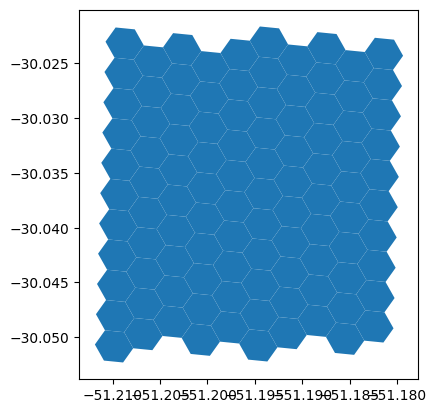

In [ ]:
#importação das bibliotecas utilizadas
import h3
import shapely
import geopandas as gpd

norte = -30.022707751637032
sul = -30.05085285614069
leste = -51.1799571518323
oeste = -51.211054845762206

#definição das coordenadas da área de análise
vertices = [ [oeste, norte], [leste, norte], [leste, sul], [oeste, sul] ]

#criamos um polígono a partir dos vertices
poligono = shapely.Polygon( vertices )

#criação de um GDF contendo apenas o polígono a ser utilizado como referência
area_analise = gpd.GeoDataFrame(crs='EPSG:4326', geometry=[poligono])

#obtenção dos dados dos hexágonos que interseccionam área de análise
hexs = h3.polyfill( area_analise.geometry[0].__geo_interface__, res = 9, geo_json_conformant = True )

#criação de lista para armazenar poligonos
lista_poligonos = []

#para cada id obtido no bloco de código acima, obtemos sua geometria
for hex_id in hexs:
  poligono = shapely.Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))
  lista_poligonos.append(poligono)

#criamos GDF contendo a geometria e o id de cada hexágono
all_polys = gpd.GeoSeries((lista_poligonos), index=hexs, crs="EPSG:4326")
malha_hexagonal = gpd.GeoDataFrame({"geometry": all_polys, "hex_id": all_polys.index}, crs=all_polys.crs)

#mostra geometrias na tela
malha_hexagonal.plot()

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


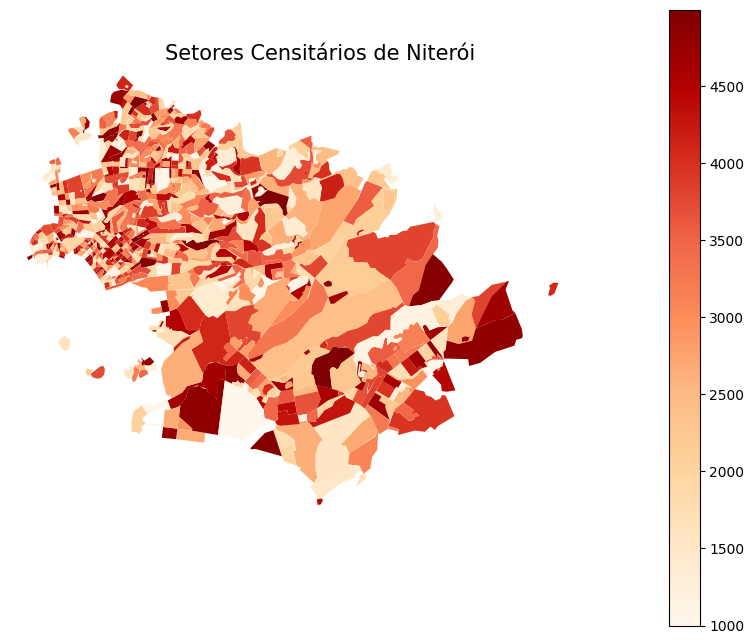

In [ ]:
import numpy as np
# Carregar os setores censitários de Niterói
setores = geobr.read_census_tract(code_tract="RJ", year=2010)

# Filtrar os setores apenas para Niterói
niteroi_bounds = geobr.read_municipality(code_muni=3303302, year=2010).geometry.iloc[0]
setores_niteroi = setores[setores.geometry.within(niteroi_bounds)]

setores_niteroi['teste'] = np.random.randint(1000, 5000, len(setores_niteroi))

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plotar os setores censitários de Niterói
setores_niteroi.plot(column='teste', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.8', legend=True)

# Adicionar título e rótulo aos eixos
ax.set_title('Setores Censitários de Niterói', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_axis_off()

# Ajustar a visualização para focar em Niterói
ax.set_xlim(niteroi_bounds.bounds[0], niteroi_bounds.bounds[2])
ax.set_ylim(niteroi_bounds.bounds[1], niteroi_bounds.bounds[3])

# Mostrar o mapa
plt.show()


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


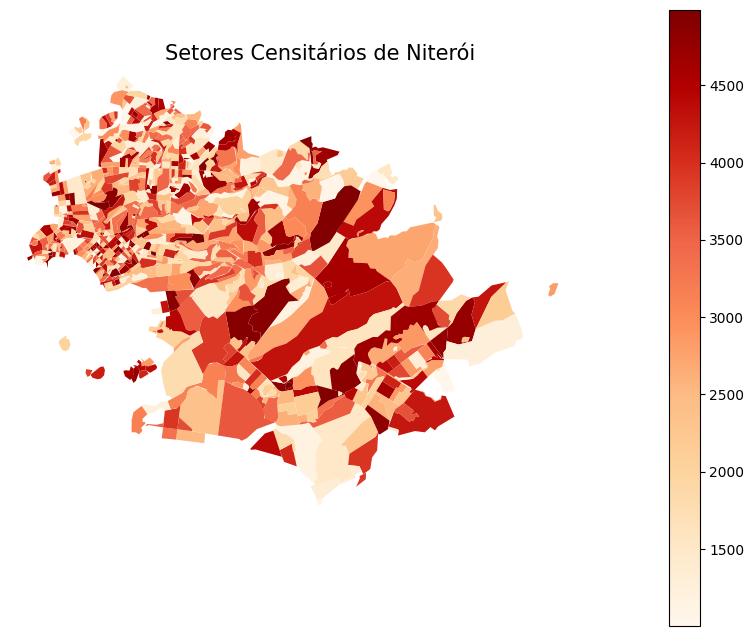

In [ ]:
import numpy as np
# Carregar os setores censitários de Niterói
setores = geobr.read_census_tract(code_tract="RJ", year=2010)

# Filtrar os setores apenas para Niterói
niteroi_bounds = geobr.read_municipality(code_muni=3303302, year=2010).geometry.iloc[0]
setores_niteroi = setores[setores.geometry.within(niteroi_bounds)]

setores_niteroi['teste'] = np.random.randint(1000, 5000, len(setores_niteroi))

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plotar os setores censitários de Niterói
setores_niteroi.plot(column='teste', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.8', legend=True)

# Adicionar título e rótulo aos eixos
ax.set_title('Setores Censitários de Niterói', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_axis_off()

# Ajustar a visualização para focar em Niterói
ax.set_xlim(niteroi_bounds.bounds[0], niteroi_bounds.bounds[2])
ax.set_ylim(niteroi_bounds.bounds[1], niteroi_bounds.bounds[3])

# Mostrar o mapa
plt.show()


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


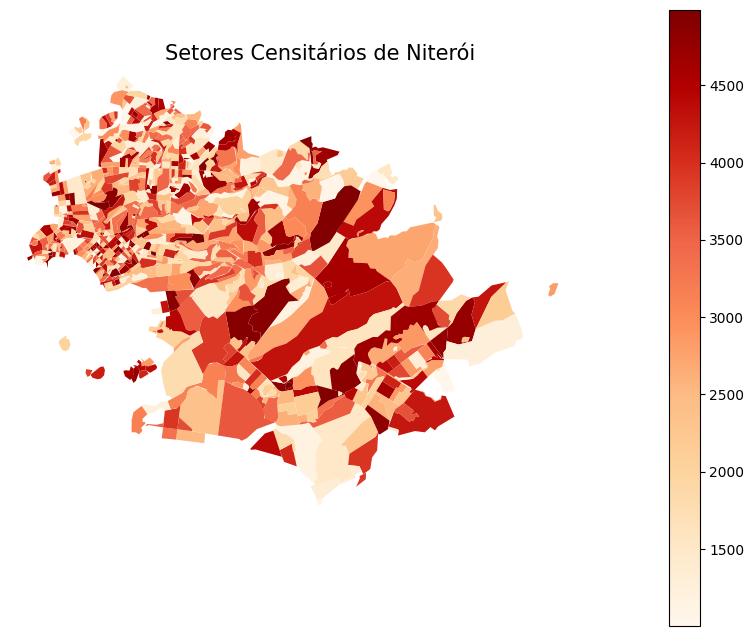

In [ ]:
import numpy as np
# Carregar os setores censitários de Niterói
setores = geobr.read_census_tract(code_tract="RJ", year=2010)

# Filtrar os setores apenas para Niterói
niteroi_bounds = geobr.read_municipality(code_muni=3303302, year=2010).geometry.iloc[0]
setores_niteroi = setores[setores.geometry.within(niteroi_bounds)]

setores_niteroi['teste'] = np.random.randint(1000, 5000, len(setores_niteroi))

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plotar os setores censitários de Niterói
setores_niteroi.plot(column='teste', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.8', legend=True)

# Adicionar título e rótulo aos eixos
ax.set_title('Setores Censitários de Niterói', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_axis_off()

# Ajustar a visualização para focar em Niterói
ax.set_xlim(niteroi_bounds.bounds[0], niteroi_bounds.bounds[2])
ax.set_ylim(niteroi_bounds.bounds[1], niteroi_bounds.bounds[3])

# Mostrar o mapa
plt.show()


#####***Infraestrutura de transporte***

In [ ]:
#Avaliação dos modais de mobilidade da cidade
#Pontos ficticios de metrô / A ideia é inserir os pontos de ônibus da cidade

import folium
from folium.plugins import MeasureControl
from geobr import read_municipality

# Carregar os dados geoespaciais de Niterói
niteroi = read_municipality(code_muni=3303302, year=2020)

# Coordenadas centrais de Niterói para centralizar o mapa
latitude = -22.885897
longitude = -43.115299

# Cria um mapa centralizado em Niterói
map_niteroi = folium.Map(location=[latitude, longitude], zoom_start=14)

# Adiciona os limites de Niterói
folium.GeoJson(niteroi, style_function=lambda x: {'color': 'black', 'weight': 2, 'fillColor': 'black', 'fillOpacity': 0.1}, name='Niterói').add_to(map_niteroi)

# Dados de pontos de metrô de Niterói (exemplo fictício)
metro_stations = [
    {"name": "Metrô Praça Arariboia", "location": [-22.893672020274934, -43.12445234890974]},
    {"name": "Metrô Centro", "location": [-22.89400112560137, -43.118915026270116]},
]

# Adicionar pontos de metrô ao mapa e criar buffers
for station in metro_stations:
    folium.Marker(
        location=station["location"],
        popup=station["name"],
        icon=folium.Icon(color='red', icon='train')
    ).add_to(map_niteroi)

    # Criar buffers de 500m e 1000m
    folium.Circle(
        location=station["location"],
        radius=500,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.2,
        popup=f'Buffer 500m de {station["name"]}'
    ).add_to(map_niteroi)

    folium.Circle(
        location=station["location"],
        radius=1000,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.2,
        popup=f'Buffer 1000m de {station["name"]}'
    ).add_to(map_niteroi)

# Adicionar controle de medida
map_niteroi.add_child(MeasureControl())

# Adicionar uma legenda personalizada
legend_html = '''
     <div style="
     position: fixed;
     bottom: 50px; left: 50px; width: 200px; height: 120px;
     background-color: white;
     border:2px solid grey;
     z-index:9999;
     font-size:14px;
     ">
     &nbsp; <b>Legenda</b> <br>
     &nbsp; <i style="color:black;">&#9679;</i>&nbsp; Niterói <br>
     &nbsp; <i style="color:red;" class="fa fa-train"></i>&nbsp; Estações de Metrô <br>
     &nbsp; <i style="color:green;">&#9679;</i>&nbsp; Buffer 500m <br>
     &nbsp; <i style="color:blue;">&#9679;</i>&nbsp; Buffer 1000m <br>
     </div>
     '''

map_niteroi.get_root().html.add_child(folium.Element(legend_html))

# Adicionar a camada de controle
folium.LayerControl().add_to(map_niteroi)

# Salvar o mapa em um arquivo HTML
map_niteroi.save('map_niteroi.html')

# Exibir o mapa
map_niteroi